In [25]:
# want to store this notebook in the notebooks folder, but want to keep non-relative imports
import os
os.chdir('..')

In [2]:
import os
import sys
import time
import copy
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
from torch.autograd import Variable
from itertools import repeat
import sklearn

import models, models.graphLayer, models.models
import data, data.gene_datasets, data.graph


/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tcgatissue = data.gene_datasets.TCGATissue(data_dir='/data/lisa/data/genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
#tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [4]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [5]:
graph = data.graph.Graph()
#path = "ae2691e4f4f068d32f83797b224eb854b27bd3ee" # Gene mania hash
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [6]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = sorted(first_degree - results)
            results.add(unique.pop())
        elif len(second_degree) - len(results) > 0:
            unique = sorted(second_degree - results)
            results.add(unique.pop())
        else:
            unique = sorted(all_nodes - results)
            results.add(unique.pop())
    return results

In [7]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True, attention_head=0, l1_loss_lambda=0, model_reg_lambda=0, training_mode=None, pool=False, prepool_extralayers=0):
        self.model = model
        self.batch_size = 5
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        self.patience = 10
        self.attention_head = attention_head
        self.l1_loss_lambda = l1_loss_lambda
        self.model_reg_lambda = model_reg_lambda
        self.training_mode = training_mode
        self.pool = pool
        self.prepool_extralayers = prepool_extralayers
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size*2, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.50, random_state=seed)
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = torch.nn.CrossEntropyLoss(size_average=True)
        patience = self.patience
        opt.num_layer = self.num_layer
        
        if self.model == "CGN":
            opt2 = copy.copy(opt)
            if self.pool:
                opt2.pool_graph = "hierarchy"
            else:
                opt2.pool_graph = "ignore"
            adj_transform, aggregate_function = models.graphLayer.get_transform(adj, opt2.graph, opt2.cuda, num_layer=self.num_layer)
            model = models.models.CGN(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1,
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj,
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform,
                    aggregate_adj=aggregate_function,
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=self.attention_head, 
                    prepool_extralayers=self.prepool_extralayers
                    )
        elif self.model == "MLP":
            model = models.models.MLP(
                    len(dataset.df.columns), 
                    channels=[self.num_channel] * self.num_layer, 
                    out_dim=2, 
                    on_cuda=self.cuda, 
                    dropout=self.dropout)
        elif self.model == "SLR":
            model = models.models.SparseLogisticRegression(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    adj=adj, 
                    out_dim=2, 
                    on_cuda=self.cuda)
        elif self.model == "LCG":
            opt2 = copy.copy(opt)
            if self.pool:
                opt2.pool_graph = "hierarchy"
            else:
                opt2.pool_graph = "ignore"
            adj_transform, aggregate_function = models.graphLayer.get_transform(adj, opt2.graph, opt2.cuda)
            model = models.models.LCG(
                    nb_nodes=len(dataset.df.columns), 
                    input_dim=1, 
                    channels=[self.num_channel] * self.num_layer,
                    adj=adj, 
                    out_dim=2,
                    on_cuda=self.cuda,
                    add_emb=self.add_emb,
                    transform_adj=adj_transform, 
                    aggregate_adj=aggregate_function, 
                    use_gate=self.use_gate,
                    dropout=self.dropout,
                    attention_head=nb_attention_head, 
                    training_mode=training_mode)
            
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        l1_criterion = torch.nn.L1Loss(size_average=False)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        max_valid_test = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)
                
                # Compute and print loss
                targets = Variable(labels, requires_grad=False).long()
                crit_loss = criterion(y_pred, targets)
                model_regularization_loss = model.regularization(self.model_reg_lambda)
                l1_loss = models.models.setup_l1_loss(model, self.l1_loss_lambda, l1_criterion, opt.cuda)
                total_loss = crit_loss + model_regularization_loss + l1_loss
                

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()

            auc = {}
            res = []
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs = Variable(local_X_train[base_x:base_x+self.batch_size], requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                res.append(model(inputs)[:,1].data.cpu().numpy())
            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,local_X_valid.shape[0], self.batch_size):
                inputs = Variable(local_X_valid[base_x:base_x+self.batch_size], requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                res.append(model(inputs)[:,1].data.cpu().numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, np.asarray(res).flatten())
            
            res = []
            for base_x in range(0,X_test.shape[0], self.batch_size):
                inputs = Variable(X_test[base_x:base_x+self.batch_size], requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                res.append(model(inputs)[:,1].data.cpu().numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, np.asarray(res).flatten())
            
            
            time_this_epoch = time.time() - start_timer

#eval on cpu
#             auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
#             auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            # print summary

            patience = patience - 1
            if patience == 0:
                return max_valid_test
                break
            if (max_valid < auc['valid']) and t > 5:
                max_valid = auc['valid']
                max_valid_test = auc['test']
                patience = self.patience

In [8]:
def method_comparison(results, dataset, models, gene, search_num_genes, trials, search_train_size, test_size):
    
    # dataset = data.gene_datasets.TCGATissue(data_dir='/data/lisa/data/genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
    # dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    for train_size in search_train_size:
        for ex in search_num_genes:

            num_genes = ex
            num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
            print ex, num_genes

            neighbors = sample_neighbors(g, gene, num_genes, include_self=True)
            print "neighbors", len(neighbors), "train_size", train_size
            
            dataset.df = dataset.df[list(neighbors)]
            dataset.df[gene] = 1
            dataset.data = dataset.df.as_matrix()
            
            neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
            for model in models:
                for seed in range(trials):

                    #have we already done it?
                    already_done = results["df"][(results["df"].gene_name == gene) & 
                                                 (results["df"].model == model['key']) &
                                                 (results["df"].num_genes == num_genes) &
                                                 (results["df"].seed == seed) &
                                                 (results["df"].train_size == train_size)].shape[0] > 0

                    if already_done:
                        print "already done:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed
                        continue
                    print "doing:", model['key'], "num_genes", num_genes, "train_size", train_size, "seed", seed
                    result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                    experiment = {"gene_name": gene,
                            "model": model['key'],
                            "num_genes": num_genes, 
                            "seed":seed,
                            "train_size": train_size,
                            "auc":result
                            }

                    results["df"] = results["df"].append(experiment, ignore_index=True)
                    pickle.dump(results, open("results_temp.pkl", "wb"))
            dataset.df = full_df
    

In [9]:
m = [
        {'key': 'MLP_lay2_chan512_dropout', 'method': PyTorch("MLP", cuda=True,dropout=True, num_layer=2, num_channel=512)},
        {'key': 'MLP_lay2_chan512', 'method': PyTorch("MLP", cuda=True, dropout=False, num_layer=2, num_channel=512)},
        {'key': 'SLR_lambda1_l11', 'method': PyTorch("SLR", cuda=True, model_reg_lambda=1, l1_loss_lambda=1)},
        {'key': 'CGN_lay3_chan64_emb32_dropout', 'method': PyTorch("CGN", cuda=True, num_layer=3,num_channel=64, add_emb=32 )},
        {'key': 'CGN_lay20_chan32_emb32_dropout_pool', 'method': PyTorch("CGN", cuda=True, num_layer=4, num_channel=32, add_emb=32, pool=True, prepool_extralayers=5)},  
    ]

In [10]:
try:
    results = pickle.load(open("results_temp.pkl", "r"))
except Exception:
    results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}



In [ ]:
a = method_comparison(results, tcgatissue, m, gene="C15orf40", 
                      search_num_genes=[50, 100,200,300,500, 1000, 2000,4000, 8000, 16000], 
                      trials=5, search_train_size=[50], test_size=1000)

50 50
neighbors 50 train_size 50
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 0
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 1
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 2
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 3
already done: MLP_lay2_chan512_dropout num_genes 50 train_size 50 seed 4
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 0
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 1
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 2
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 3
already done: MLP_lay2_chan512 num_genes 50 train_size 50 seed 4
already done: SLR_lambda1_l11 num_genes 50 train_size 50 seed 0
already done: SLR_lambda1_l11 num_genes 50 train_size 50 seed 1
already done: SLR_lambda1_l11 num_genes 50 train_size 50 seed 2
already done: SLR_lambda1_l11 num_genes 50 train_size 50 seed 3
already done: SLR_lam

/u/weissmar/venv/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


already done: MLP_lay2_chan512_dropout num_genes 200 train_size 50 seed 0
already done: MLP_lay2_chan512_dropout num_genes 200 train_size 50 seed 1
already done: MLP_lay2_chan512_dropout num_genes 200 train_size 50 seed 2
already done: MLP_lay2_chan512_dropout num_genes 200 train_size 50 seed 3
already done: MLP_lay2_chan512_dropout num_genes 200 train_size 50 seed 4
already done: MLP_lay2_chan512 num_genes 200 train_size 50 seed 0
already done: MLP_lay2_chan512 num_genes 200 train_size 50 seed 1
already done: MLP_lay2_chan512 num_genes 200 train_size 50 seed 2
already done: MLP_lay2_chan512 num_genes 200 train_size 50 seed 3
already done: MLP_lay2_chan512 num_genes 200 train_size 50 seed 4
already done: SLR_lambda1_l11 num_genes 200 train_size 50 seed 0
already done: SLR_lambda1_l11 num_genes 200 train_size 50 seed 1
already done: SLR_lambda1_l11 num_genes 200 train_size 50 seed 2
already done: SLR_lambda1_l11 num_genes 200 train_size 50 seed 3
already done: SLR_lambda1_l11 num_genes 

neighbors 4000 train_size 50
already done: MLP_lay2_chan512_dropout num_genes 4000 train_size 50 seed 0
already done: MLP_lay2_chan512_dropout num_genes 4000 train_size 50 seed 1
already done: MLP_lay2_chan512_dropout num_genes 4000 train_size 50 seed 2
already done: MLP_lay2_chan512_dropout num_genes 4000 train_size 50 seed 3
already done: MLP_lay2_chan512_dropout num_genes 4000 train_size 50 seed 4
already done: MLP_lay2_chan512 num_genes 4000 train_size 50 seed 0
already done: MLP_lay2_chan512 num_genes 4000 train_size 50 seed 1
already done: MLP_lay2_chan512 num_genes 4000 train_size 50 seed 2
already done: MLP_lay2_chan512 num_genes 4000 train_size 50 seed 3
already done: MLP_lay2_chan512 num_genes 4000 train_size 50 seed 4
already done: SLR_lambda1_l11 num_genes 4000 train_size 50 seed 0
already done: SLR_lambda1_l11 num_genes 4000 train_size 50 seed 1
already done: SLR_lambda1_l11 num_genes 4000 train_size 50 seed 2
already done: SLR_lambda1_l11 num_genes 4000 train_size 50 seed

/u/weissmar/venv/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Doing drop-out


/u/weissmar/venv/lib/python2.7/site-packages/ipykernel_launcher.py:197: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


doing: CGN_lay3_chan64_emb32_dropout num_genes 8000 train_size 50 seed 1
Doing drop-out
doing: CGN_lay3_chan64_emb32_dropout num_genes 8000 train_size 50 seed 2
Doing drop-out
doing: CGN_lay3_chan64_emb32_dropout num_genes 8000 train_size 50 seed 3
Doing drop-out
doing: CGN_lay3_chan64_emb32_dropout num_genes 8000 train_size 50 seed 4


In [45]:
#results["df"] = results["df"].replace("wRPL5_CGN_3_layer_64_channel_emb_32_dropout", "CGN_3_layer_64_channel_emb_32_dropout")

In [39]:
#pickle.dump(results, open("results-temp.pkl", "wb"))

In [83]:
import pickle
#pickle.dump(results, open("results-temp.pkl", "wb"))

In [26]:
#results = pickle.load(open("exp-results/results-S100A8.pkl", "r"))

In [11]:
# results["df"]

In [102]:
#q = results["df"][(results["df"].model == "CGN_2_layer_512_channel_emb_512_dropout")]
#q

In [103]:
#results["df"] = results["df"].drop(q.index)

In [81]:
#results["df"].gene_name.unique()

In [10]:
# grouped = results["df"][results["df"].gene_name=="S100A8"].groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
# grouped

In [279]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

In [82]:
#results["df"][(results["df"].gene_name==plot_gene)]

In [5]:
import pickle
results = pickle.load(open("results-temp.pkl", "r"))

NameError: name 'index' is not defined

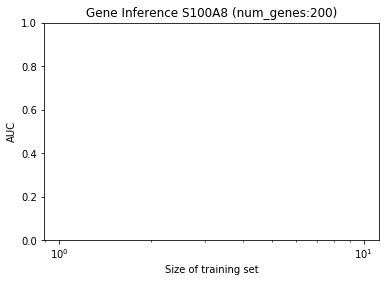

In [11]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plot_gene = "S100A8"
plot_num_genes = 200

subset = results["df"][(results["df"].num_genes==plot_num_genes) & 
                      (results["df"].gene_name==plot_gene)]

q = subset.groupby(['model','train_size'])['auc']

#for model in ['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:#
for model in subset["model"].unique():
    index = q.mean()[model].index
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference " + plot_gene + " (num_genes:" + str(plot_num_genes) +")")
plt.ylabel("AUC")
plt.xlabel("Size of training set")
plt.xscale("log")
plt.xticks(index)
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [90]:
results["df"].model.unique()

array(['CGN_3_layer_64_channel_emb_32_dropout',
       'CGN_2_layer_512_channel_emb_512_dropout', 'MLP_2_chan512-dropout',
       'MLP_2_chan512', 'SLR2=lambda10-l1-1'], dtype=object)

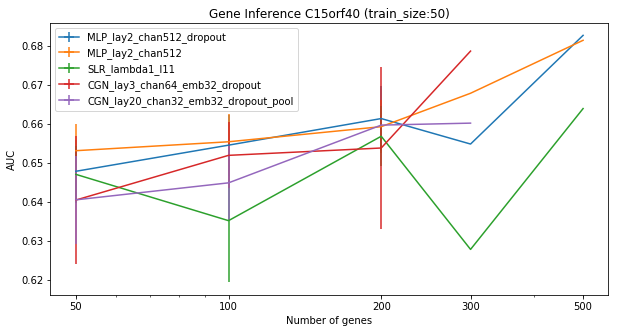

In [126]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
plot_gene = "C15orf40"
plot_train_size = 50

subset = results["df"][(results["df"].train_size==plot_train_size) & 
                  (results["df"].gene_name==plot_gene) & 
                  (results["df"].num_genes> 0)]


q = subset.groupby(['model','num_genes'])['auc']

#['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:
#for model in ['CGN_2_layer_512_channel_emb_512_dropout', "MLP_2_chan512", "SLR2=lambda10-l1-1"]:
for model in subset["model"].unique():
    index = list(q.mean()[model].index)
    mean = q.mean()[model]
    stderr = q.std()[model]/np.sqrt(q.count()[model])
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)

plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
plt.ylabel("AUC")
plt.xlabel("Number of genes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
#plt.xlim(40,4500)
plt.legend();